In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *

import pandas as pd

p = Project.objects.get(pk=260)
qs = p.query_set.all()
q = Query.objects.get(pk=8843)

dids = set(Doc.objects.filter(query__in=qs).values_list('pk', flat=True))
len(dids)

565085

In [2]:
regenerate_docinfo = False
if regenerate_docinfo:
    df = pd.DataFrame.from_dict(Doc.objects.filter(pk__in=dids).values('id','PY','title','wosarticle__dt'))
    df.columns = ["id","Publication Year","Title","Keywords"]
    df.head()
    df.to_csv('data/0c_doc_info.csv',index=False)

In [3]:

django.db.connection.close()

dos = DocOwnership.objects.filter(tag__query__project=p, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

# Get relevant / not relevant decisions
do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = np.NaN
do_df.head()

# Get category assignment
cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'category__name',
        'category__level',
        'user__username',
        'countries__name',
        'texts__name',
        'selection_tier'
    )
)
# Filter so that it matches the relevant set
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]

# Rename category to capture level
df['category__level'] = df['category__level'].astype(str)
df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
#df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)

# Capture the primary/secondary value (1 for primary, 2 for secondary)
df['val'] = df['selection_tier']

# Set the value to the country / text where appropriate and j
df.loc[~pd.isna(df['countries__name']),'val'] = df.loc[~pd.isna(df['countries__name']),'countries__name']
df.loc[~pd.isna(df['texts__name']),'val'] = df.loc[~pd.isna(df['texts__name']),'texts__name']

cats = df['Category Name'].unique()

df.head()

,doc__id,doc__title,doc__content,category__name,category__level,user__username,countries__name,texts__name,selection_tier,Category Name,val
0,3857447,BANKING AND BORROWING IN THE EU ETS: A REVIEW ...,This paper deals with the issue of banking and...,1. Economic instruments,4,lucy.banisch@icloud.com,None,None,1,4 - 1. Economic instruments,1
1,378230,Time flexibility to reduce climate change miti...,The idea of greenhouse-gas credit borrowing in...,1. Economic instruments,4,vasudevan@mcc-berlin.net,None,None,1,4 - 1. Economic instruments,1
2,790083,Carbon emissions of urban power grid in Jing-J...,Rapid urbanization drives the expansion of urb...,1. Economic instruments,4,vasudevan@mcc-berlin.net,None,None,1,4 - 1. Economic instruments,1
3,24949,Distributional effects of carbon allowance tra...,"if the U.S. should limit CO2 emissions, an all...",1. Economic instruments,4,edmondson@hertie-school.org,None,None,1,4 - 1. Economic instruments,1
4,249492,Emission abatement: Untangling the impacts of ...,In this study we use historical emission data ...,1. Economic instruments,4,lucy.banisch@icloud.com,None,None,1,4 - 1. Economic instruments,1


In [4]:
# Merge relevant/not relevant with categories
do_df['Category Name'] = "0 - relevant"

merged_df = pd.concat([
    df[['doc__id','doc__title','doc__content','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
])
merged_df.tail()

,doc__id,doc__title,doc__content,user__username,Category Name,val
3223,1838661,Cultural and Social Elements in the Developmen...,In the context of climate change and energy cr...,doebbeling@mcc-berlin.net,0 - relevant,0
3224,315555,"GLOBAL EXPERIMENTALIST GOVERNANCE, INTERNATION...",Global experimentalist governance has emerged ...,galm,0 - relevant,1
3225,1799426,"Underdetermination, Model-ensembles and Surpri...",As climate policy decisions are decisions unde...,galm,0 - relevant,1
3226,3827028,Establishment a recycled green building materi...,This study modifies a dynamic computable gener...,vasudevan@mcc-berlin.net,0 - relevant,1
3227,3827028,Establishment a recycled green building materi...,This study modifies a dynamic computable gener...,galm,0 - relevant,1


In [5]:
# fill tag values with 0s where they have been rated
dudf_wide = (merged_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
include_policy_columns = [x for x in policy_columns if "not policy related" not in x.lower()]
print(policy_columns)
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[include_policy_columns].sum(axis=1,min_count=1)>0,"INCLUDE"] = 1
dudf_wide.loc[dudf_wide[include_policy_columns].sum(axis=1,min_count=1)==0,"INCLUDE"] = 0

dudf_wide.tail()

['3 - 0. Not policy related', '3 - 1. Analysis of an existing policy / concrete proposal', '3 - 2. Analysis of a generic policy', '3 - 3. Broader governance and policy']


Category Name,doc__id,doc__title,doc__content,user__username,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,...,8 - 10. Coastal systems and low-lying areas,8 - 11. Ocean systems,8 - 12. Food,"8 - 13. Human settlements, industry and infrastructure","8 - 14. Human health, well-being and security",8 - 15. Cross-sectoral,9 - 0. Ex-post,9 - 1. Ex-ante,9 - 2. Ex-ante (IAM),INCLUDE
3143,3878253,Effectiveness of China's plug-in electric vehi...,Subsidies for promoting plug-in electric vehic...,galm,1,0.0,0.0,China,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3144,3878253,Effectiveness of China's plug-in electric vehi...,Subsidies for promoting plug-in electric vehic...,lamw,1,0.0,0.0,China,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3145,3878253,Effectiveness of China's plug-in electric vehi...,Subsidies for promoting plug-in electric vehic...,lucy.banisch@icloud.com,1,0.0,0.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3146,3878253,Effectiveness of China's plug-in electric vehi...,Subsidies for promoting plug-in electric vehic...,muef,1,0.0,0.0,China,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3147,3878253,Effectiveness of China's plug-in electric vehi...,Subsidies for promoting plug-in electric vehic...,vasudevan@mcc-berlin.net,1,0.0,0.0,China,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
# Now get a single value for each document by choosing the most common selection
import statistics
def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
# First make it long, so that each row is a doc-category-user rating
xdf = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','user__username'])

# Now group by doc and category, and take the mode
xdf = xdf.groupby(['doc__id','doc__title','doc__content','Category Name'])['value'].agg(lambda x: mode_na(x)).reset_index()

# Now pivot so that each category is a column
seen_df = xdf.pivot(index=["doc__id","doc__title","doc__content"],columns="Category Name").reset_index()
print(seen_df.shape)

seen_df.columns = [col[1] if col[1] !="" else col[0] for col in seen_df.columns]

print(seen_df[pd.isna(seen_df['0 - relevant'])].shape)

seen_df.head()

(1385, 104)
(194, 104)


,doc__id,doc__title,doc__content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,2 - 1. Adaptation,...,8 - 10. Coastal systems and low-lying areas,8 - 11. Ocean systems,8 - 12. Food,"8 - 13. Human settlements, industry and infrastructure","8 - 14. Human health, well-being and security",8 - 15. Cross-sectoral,9 - 0. Ex-post,9 - 1. Ex-ante,9 - 2. Ex-ante (IAM),INCLUDE
0,156,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,Magma power is the production of electricity f...,1,NaN,NaN,NaN,NaN,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,921,Ontology engineering in provenance enablement ...,The National Climate Assessment of the U.S. Gl...,1,NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1448,"Planning, governance and rural futures in Aust...",Rural regions in post-industrial countries con...,0,NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3556,Will economic restructuring in China reduce tr...,We calculate carbon dioxide (CO2) emissions em...,1,1,NaN,China,NaN,1,0,...,0,0,0,0,0,NaN,1,0,0,1
4,3679,Forcing and response in simulated 20th and 21s...,A simple methodology is applied to a transient...,NaN,NaN,NaN,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [7]:
renamings = [
    ("5 - 2.07. Spatial and land-use planning","5 - 2.09. Spatial and land-use planning"),
    ("5 - 2.07. Spatial and land-use planning","6 - 2.09. Spatial and land-use planning"),
    ("5 - 5.17. Inter/transnational agreements","5 - 5.20. Inter/transnational agreements"),
    ("5 - 5.17. Inter/transnational agreements","6 - 5.20. Inter/transnational agreements"),
    ("Analysis of a specific policy","Analysis of an existing policy / concrete proposal"),
    ("Governance and planning", "Governance, strategies and targets"),
    ("5 - 2.08. Other regulation", "5 - 2.10. Other regulation"),
    ("5 - 2.08. Other regulation", "6 - 2.10. Other regulation"),
    ("Other institutions or agencies", "Other institutional arrangements"),
    ("5 - 3.11. Behavioural interventions", "5 - 3.13. Behavioural interventions"),
    ("5 - 3.11. Behavioural interventions", "6 - 3.02. Behavioural interventions"),
    ("5 - 3.12. Education and training","5 - 3.14. Education and training"),  
    
]

In [8]:
# Loop through the comparison/resolution files and resolve labelled dataset
for fname in os.listdir("decision_resolutions"):
    if ".xlsx" in fname:
        cdf = pd.read_excel(f'decision_resolutions/{fname}',sheet_name="comparison")
    dcolumn = [x for x in cdf.columns if "decision" in x.lower()][0]
    cdf = cdf[pd.notna(cdf[dcolumn])]
    
    for i, row in cdf.iterrows():
        try:
            x = int(row[dcolumn])
        except:
            #print(f"could not parse {row[dcolumn]}")
            continue
        cname = row['Category Name']
        
        for r1, r2 in renamings:
            cname = cname.replace(r1,r2)
        if cname not in seen_df.columns:
            matches = [x for x in seen_df.columns if cname.split('. ')[1] in x]
            if len(matches) == 1:
                cname = matches[0]
            else:
                print(cname)
                continue
            
        seen_df.loc[(seen_df['doc__id']==row['doc__id']),cname] = row[dcolumn]

5 – 4.17. Government administration & management 


In [9]:
cdf.head()

,doc__id,doc__title,doc__content,Category Name,ceposadap@gmail.com,doebbeling@mcc-berlin.net,galm,lucy.banisch@icloud.com,vasudevan@mcc-berlin.net,agreement,decision
2,30504,The Food System and Climate Change: An Explora...,Using existing literature and a modified lifec...,10 - 4. Qualitative,1,NaN,0,NaN,NaN,0,1
50,30504,The Food System and Climate Change: An Explora...,Using existing literature and a modified lifec...,7 - 1. National,1,NaN,0,NaN,NaN,0,1
58,30504,The Food System and Climate Change: An Explora...,Using existing literature and a modified lifec...,8 - 06. Waste,1,NaN,0,NaN,NaN,0,0
493,119832,The performance of the Norwegian carbon dioxid...,In order to take up Norway's twin challenge of...,8 - 15. Cross-sectoral,0,NaN,1,NaN,NaN,0,1
495,119832,The performance of the Norwegian carbon dioxid...,In order to take up Norway's twin challenge of...,9 - 1. Ex-ante,1,NaN,0,NaN,NaN,0,1


In [10]:
# Now label Inclusion (simply the presence of any policy type)
include_policy_columns = [x for x in policy_columns if "not policy related" not in x.lower()]

seen_df.loc[seen_df[include_policy_columns].max(axis=1).isin([1,2,np.NaN]),"INCLUDE"] = 1
seen_df.loc[pd.isna(seen_df[include_policy_columns]).any(axis=1),"INCLUDE"] = 1
seen_df[["doc__title","0 - relevant"] + policy_columns + ["INCLUDE"]].head(15)

,doc__title,0 - relevant,3 - 0. Not policy related,3 - 1. Analysis of an existing policy / concrete proposal,3 - 2. Analysis of a generic policy,3 - 3. Broader governance and policy,INCLUDE
0,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,1,1,0,0,0,0
1,Ontology engineering in provenance enablement ...,1,NaN,0,0,0,0
2,"Planning, governance and rural futures in Aust...",0,0,0,0,0,0
3,Will economic restructuring in China reduce tr...,1,0,NaN,NaN,0,1
4,Forcing and response in simulated 20th and 21s...,1,1,0,0,0,0
5,Egeson's (George's) transtridecadal weather cy...,0,0,0,0,0,0
6,An emerging equilibrium in the EU emissions tr...,1,0,1,0,0,1
7,Adapting production forests in southern Sweden...,1,0,0,0,0,0
8,Dual climate change responsibility: on moral d...,1,NaN,0,0,0,0
9,Vegetation structure and biodiversity along th...,0,0,0,0,0,0


In [16]:
# Tag whether the document is part of a representative sample
django.db.connection.close()
seen_df["representative_sample"] = 0
random_tags = Tag.objects.filter(query__project=p, title__icontains="representative")
random_ids = set(DocOwnership.objects.filter(tag__in=random_tags, relevant__gt=0).values_list('doc__id',flat=True))
seen_df.loc[seen_df['doc__id'].isin(random_ids),"representative_sample"] = 1

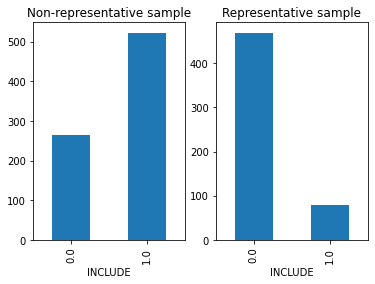

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
labels = ["Non-representative sample","Representative sample"]
for name, group in seen_df.groupby(['representative_sample']):
    ax = axs[name]
    ax.set_title(labels[name])
    
    group.groupby('INCLUDE').size().plot.bar(ax=ax)

In [19]:
seen_df.rename(
    columns={"doc__id":"id","doc__content":"content","doc__title":"title"}
).to_csv('data/0_labelled_documents.csv',index=False)

In [14]:
columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_docs = Doc.objects.filter(
    id__in=dids,
    content__iregex='\w',
).exclude(pk__in=seen_df['doc__id'])

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0
unseen_df['random'] = 0

print(unseen_df.shape)
unseen_df.to_csv('data/0_unlabelled_documents.csv', index=False)
unseen_df.head()

(529813, 8)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,random
0,2125,Climate change affects hydropower production b...,Climate Change Impacts on Hydropower Management,Climate change; Hydropower management; Electri...,"[Engineering, Civil; Water Resources]",0,0,0
1,3623,Mediterranean coastal dunes are dynamic and he...,Mediterranean coastal dune systems: Which abio...,Canonical Correspondence Analysis (CCA); geomo...,[Marine & Freshwater Biology; Oceanography],0,0,0
2,4020,The fossil flora recovered from the Kangvai we...,Monsoon variability over Peninsular India duri...,Coexistence approach; Fossils; Konkan; Northea...,"[Geography, Physical; Geosciences, Multidiscip...",0,0,0
3,4177,Fishing and pollution are chronic stressors th...,The Micronesia Challenge: Assessing the Relati...,None,[Multidisciplinary Sciences],0,0,0
4,4297,The intramolecular distribution of stable isot...,Nitrous oxide emission from the burning of agr...,biomass burning; nitrous oxide; intramolecular...,[Environmental Sciences; Meteorology & Atmosph...,0,0,0
